Vancouver's Mobi bikeshare system has been up and running for over 2 years now, and with two full summers of activity it's time to take a look at how exactly Vancouverites are using their bikeshare system.

For over a year, I've been collecting real-time data about Mobi bike trips by monitoring public information about the number of bikes at each station and inferring trip activity based on changes to the number of bikes at each station. This has led to some fun uses: I have live figures updating constantly on [my website](data.mikejarrett.ca/mobi), a twitter bot tweets out daily stats at [@VanBikeShareBot](twitter.com/VanBikeShareBot), and a few [blog posts](http://notes.mikejarrett.ca/categories/mobi/).

As handy as those live trip estimates are, they're very much estimates and only give us information about how often certain stations are used. Luckily, Mobi has started publishing open [system data](https://www.mobibikes.ca/en/system-data). This data set gives us a registry of every Mobi bikeshare trip since the beginning of 2017, current to the end of 2018 as of this writing. With this we have access to trip start and endpoints, trip duration and distance, membership type and more. In this post, I'll summarize some of the things I've learned after spending some time looking into this data.

<!-- TEASER_END-->



## A note on the code and data

This blog post is written in a Jupyter notebook and contains the code needed to recreate all the figures and data shown. To toggle whether the raw code is displayed, click the blue button below the title of the blog. Beyond the code in this notebook, I rely on a package of python helper functions included in my [Mobi repository on github](https://github.com/mjarrett/mobi). All the data cleaning done is included in these functions except for standardizing some field names in the raw excel files. To download this post as a notebook, click the "Source" button in the top right corner.

<script>show_code = false</script>



In [1]:
# Data prep
%matplotlib notebook
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('../../mobi/')
import mobi
import numpy as np
from vanweather import get_weather_range
import matplotlib.dates as mdates

df = mobi.prep_sys_df('https://data.mikejarrett.ca/mobi/data/Mobi_System_Data.csv')
df = df.set_index('Departure')
df = df['2017-01':'2018-12']

stationdf = pd.read_json('https://data.mikejarrett.ca/mobi/data/stations_df.json')
df = mobi.add_station_coords(df,stationdf)

idx24 = np.array(df['Membership Type']=='24 Hour') | np.array(df['Membership Type']=='Archived Day')
idx90 = np.array(df['Membership Type'].str.contains('90'))
idxvcp = np.array(df['Membership Type'].str.contains('Vancity'))
idxmonthlyall = np.array(df['Membership Type'].str.contains('Monthly'))
idxsingle = np.array(df['Membership Type'].str.contains('Single'))
idxplus = np.array(df['Membership Type'].str.contains('Plus'))
idxvip = np.array(df['Membership Type'] == 'VIP')
idxnotannual = idx24 | idx90 | idxvcp | idxmonthlyall  | idxsingle | idxvip
idx365all = ~idxnotannual
idx365p = idx365all & idxplus
idx365 = idx365all & ~idxplus

## Daily trips over time

Before diving in, let's take a quick look at total Mobi trips over time. We see the the behaviour we'd expect: substantial seasona variation with some sharp dropoffs that we can assume are particularly rainy days. If you're interested in the factors that influence how many people will ride a Mobi bike on a given day, I've gone into this in more detail in a [previous post](http://notes.mikejarrett.ca/what-really-affects-bikeshare-use-in-vancouver/). Smoothing this out by averaging across each month gives us an idea of the average number of daily trips for each month.

<IPython.core.display.Javascript object>


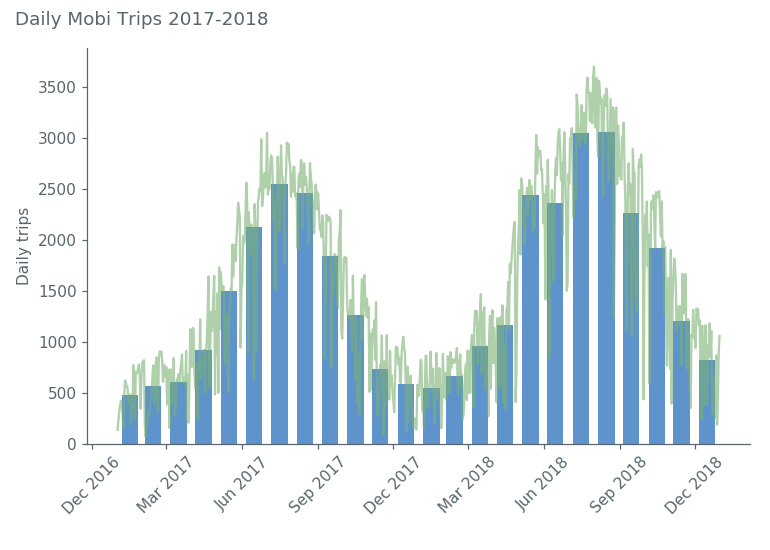

In [26]:
def tmdf(df):
    return df.groupby(pd.Grouper(freq='m')).size().index+pd.DateOffset(-15), df.groupby(pd.Grouper(freq='d')).size().groupby(pd.Grouper(freq='m')).mean()

plot = mobi.plots.Plot()
plot.ax.bar(*tmdf(df),20,alpha=0.8)
plot.ax.set_ylabel("Daily trips")
plot.ax.plot(df.groupby(pd.Grouper(freq='d')).size().index,
             df.groupby(pd.Grouper(freq='d')).size(),color=plot.fg_color,alpha=0.6)
plot.ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plot.title("Daily Mobi Trips 2017-2018")
plot.tight_layout()

In absolute terms, trips clearly up year over year. Which is great! But to get some insight into what might be driving this change let's control for some variable. First, let's normalize by the number of active stations in use in a given month.

<IPython.core.display.Javascript object>


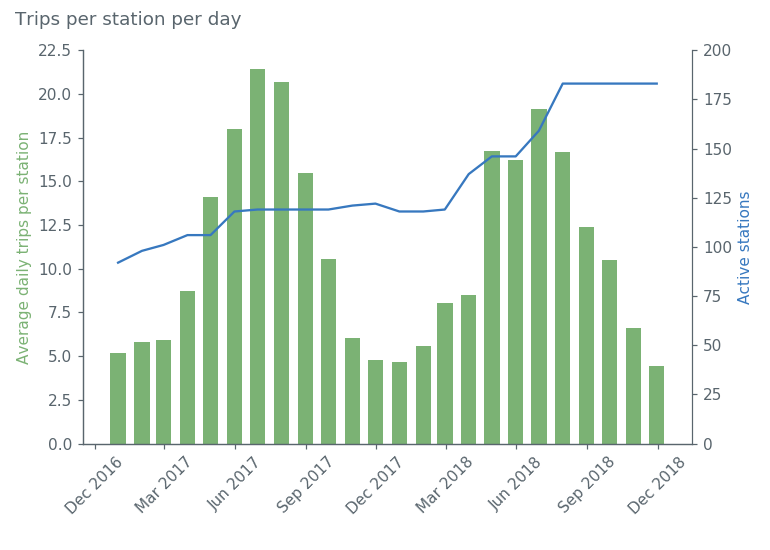

In [3]:
gdf = df.groupby(pd.Grouper(freq='m'))
plot = mobi.plots.Plot()
plot.ax.bar(gdf.size().index-1,
            df.groupby(pd.Grouper(freq='d')).size().groupby(pd.Grouper(freq='m')).mean().values/gdf['Departure station'].nunique(),
            20,
            color=plot.colors[1]
            )
plot.ax2 = plot.set_ax_props(plot.ax.twinx())
plot.ax2.plot(df.groupby(pd.Grouper(freq='m'))['Departure station'].nunique().index-1,
              df.groupby(pd.Grouper(freq='m'))['Departure station'].nunique().values)
plot.ax.spines['right'].set_visible(True)
plot.ax2.set_ylabel("Active stations")
plot.ax2.set_ylim((0,200))
plot.ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plot.ax.set_ylabel("Average daily trips per station")
plot.ax.yaxis.label.set_color(plot.fg_color)
plot.ax2.yaxis.label.set_color(plot.fg_color2)
plot.title("Trips per station per day")
plot.tight_layout()

I don't think it's a bad thing that the trips per station metric is down year over year -- spreading outside the core of Vancouver necessarily means less use at new stations, and there's lots of long-term value in having lots of stations that people can use when needed even if they're not in the highest demand areas.

Similarly, we might wonder how much of trip growth is driven by new members versus members taking more frequent trips. I don't have registration information for Mobi users so I don't know who's account is active at any given time, so I'll consider a member "active" if they've taken at least one trip in a given month. We can then normalize monthly trips by active members to look at how many trips the average member takes per month.

<IPython.core.display.Javascript object>


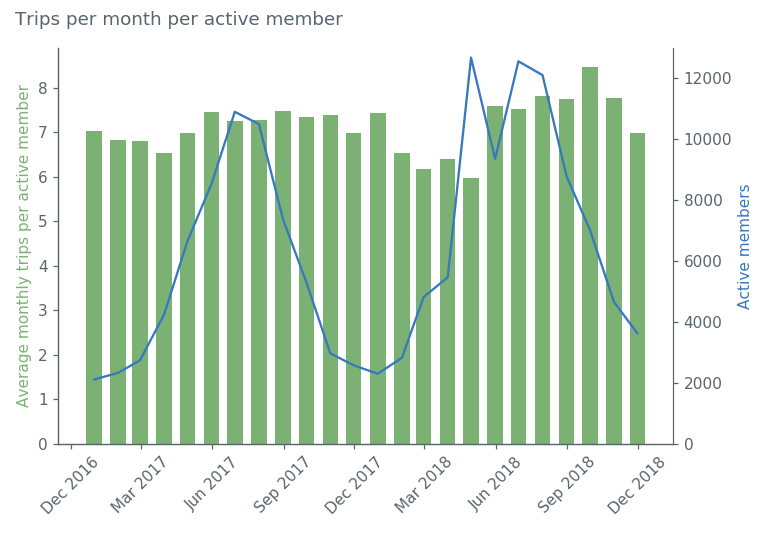

In [4]:
gdf = df.groupby(pd.Grouper(freq='m'))
plot = mobi.plots.Plot()
plot.ax.bar(gdf.size().index-1,
            gdf.size()/gdf['Account'].nunique(),
            20,
            color=plot.colors[1]
            )
plot.ax2 = plot.set_ax_props(plot.ax.twinx())
plot.ax2.plot(df.groupby(pd.Grouper(freq='m'))['Account'].nunique().index-1,
              df.groupby(pd.Grouper(freq='m'))['Account'].nunique().values)
plot.ax.spines['right'].set_visible(True)
plot.ax2.set_ylabel("Active members")
plot.ax2.set_ylim((0,13000))
plot.ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plot.ax.set_ylabel("Average monthly trips per active member")
plot.ax.yaxis.label.set_color(plot.fg_color)
plot.ax2.yaxis.label.set_color(plot.fg_color2)
plot.title("Trips per month per active member")
plot.tight_layout()

Monthly trips per active member has stayed reasonably constant over time, maybe with a slight uptick in recent months. This tells me that users joining Mobi are behaving fairly consistently over time, and the uptick in trips is due to membership growth.

## Different members types take different trips

I want to focus on the new information we have available with the official system data, so instead of just looking at raw trip counts let's instead look at how trips are distrubted over time by membership type. According to the system data, there's over a dozen membership types that have been used at one point or another, but they broadly break down into a few groups: Daily pass, monthly pass, 90 day or annual pass. All these entitle the holder to unlimited 30 minute trips for the duration of the pass. Monthly, 90 day and annual members also have the option of buying a "plus" account, which entitles them to 60 minute trips. There are a handful of other membership types -- VanCity community pass, VIP, etc -- which I'll lump together as "other".

<IPython.core.display.Javascript object>


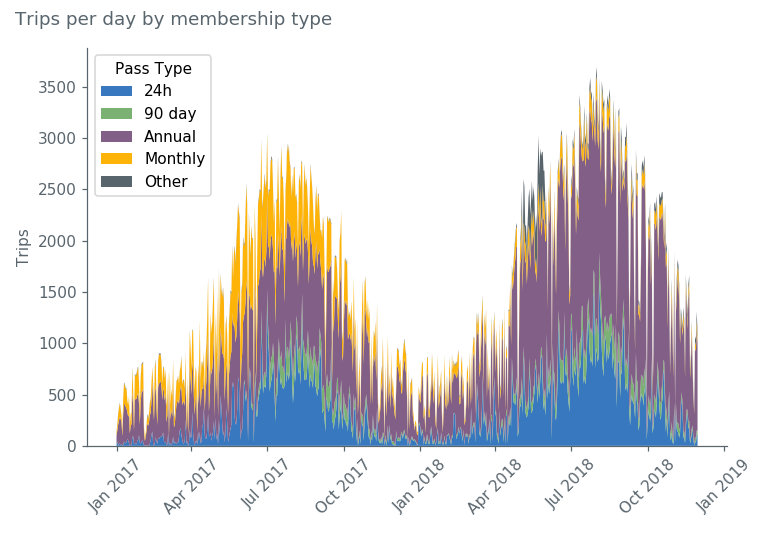

In [5]:
def tddf(df): 
    tddf = df.groupby(pd.Grouper(freq='d')).size()
    tddf = tddf.reindex(pd.date_range('01-01-2017', '11-30-2018'),fill_value=0)
    return tddf

plot = mobi.plots.Plot()
sdf = pd.DataFrame(index=tddf(df).index.values,
                   data={'Annual':tddf(df[idx365all]).values,
                         '24h':tddf(df[idx24]).values,
                         'Monthly':tddf(df[idxmonthlyall]).values,
                         '90 day':tddf(df[idx90]),
                         'Other':tddf(df[~idx24 & ~idx365all & ~idx90 & ~idxmonthlyall])})
plot.ax.stackplot(sdf.index.values,sdf.T,labels=sdf.columns,colors=plot.colors)
plot.ax.legend(loc=2,title="Pass Type")
plot.ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plot.title("Trips per day by membership type")
plot.tight_layout()

A couple main takeaways here. First, we see that the main membership types offered by Mobi have changed over type. Monthly memberships were phased out in favour of 90 day passes, and single trip passes were dropped. 

The growth in trips in 2018 over 2017 looks to be driven by annual members more than single day pass users. Annual members are also the driving force in keeping the system active during the cold and rainy months between October and April.

Let's zoom in on a shorter timeframe to see what behaviour we see on a day to day basis.

<IPython.core.display.Javascript object>


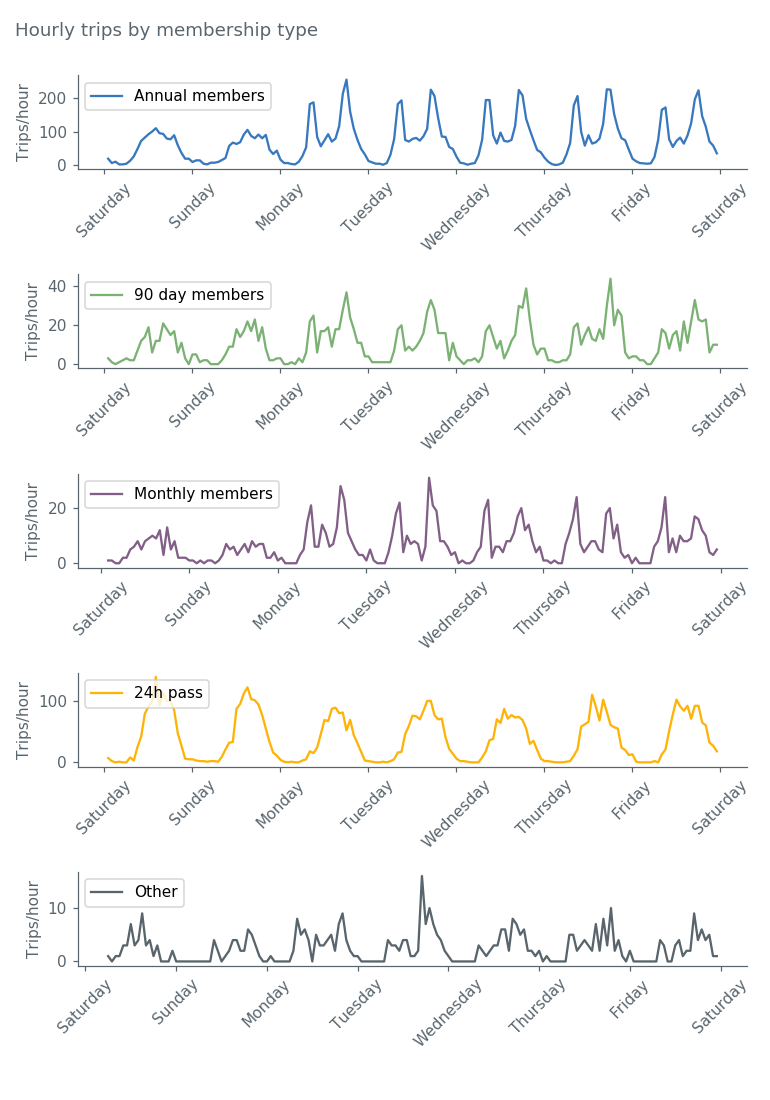

In [6]:
def thdf(df): 
    return df.groupby(pd.Grouper(freq='H')).size()
idx20180811 = np.array(df.index > '2018-08-11') & np.array(df.index < '2018-08-18')
plot = mobi.plots.Plot(5)


idxs = [idx20180811 & idx365all,idx20180811 & idx90,idx20180811 & idxmonthlyall,idx20180811 & idx24,idx20180811 & ~idx365all & ~idx90 & ~idxmonthlyall & ~idx24]
labels = ['Annual members','90 day members','Monthly members','24h pass','Other']
for idx,label,ax,c in zip(idxs,labels,plot.ax,plot.colors):
    p, = ax.plot(thdf(df[idx]),label=label,color=c)
    #ax.fill_betweenx(list(df[idx].index),list(df[idx]))
    ax.legend(loc=2)
    ax.xaxis.set_major_formatter(mdates.DateFormatter(""))
    ax.set_ylabel('Trips/hour')
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%A"))

plot.f.set_figheight(10)
plot.title("Hourly trips by membership type")
plot.tight_layout()

## Stacked line chart (cool but too confusing I think)
# def thdf(df): 
#     return df.groupby(pd.Grouper(freq='H')).size()
# idx20180811 = np.array(df.index > '2018-08-11') & np.array(df.index < '2018-08-18')
# plot = mobi.plots.Plot()
# sdf = pd.DataFrame(index=thdf(df[idx20180811]).index.values,data={'Annual':thdf(df[idx20180811 & idx365all]).values,'24h':thdf(df[idx20180811 & idx24]).values,'Monthly':thdf(df[idx20180811 & idxmonthlyall]),'90 day':thdf(df[idx20180811 & idx90]),'Other':thdf(df[~idx24 & ~idx365all & ~idx90 & idx20180811])},)
# plot.ax.stackplot(sdf.index.values,sdf.T,labels=sdf.columns,colors=plot.colors)
# plot.ax.legend(loc=2,title="Pass Type")
# plot.ax.xaxis.set_major_formatter(mdates.DateFormatter("%A"))
# plot.ax.set_ylabel('Trips/hour')
# plot.f.tight_layout()

This is a typical August week with decent weather. Saturday and Sunday basically have a normal distribution peaking in the mid-afternoon, while weekdays consistently have a narrow morning commute peak and a broader after work/evening peak (and arguably a lunchtime peak). By breaking it up by membership type we get even more insight into how people are using bike share. The weekday pattern is driven almost completely by annual and 90 day pass holders, while single-day users show roughly the same usage pattern 7 days a week, with slightly higher peaks on weekends. 

This should be reassuring to folks who worried that bike share in Vancouver would be just for tourists and would only serve to cannibalize bike rental outfits. There's no doubt that the main driver of bike share usage is local residents using the bikes to get to and from work, and around the core in the evening. These are the <a href="https://en.wikipedia.org/wiki/Last_mile_(transportation)">last mile</a> trips that transportation planners go on about, showing up plain as day in the data.

If you're interested in reading about a machine learning approach to commuter patterns, check out my [previous blog post on the topic](http://notes.mikejarrett.ca/machine-learning-with-vancouver-bike-share-data/).

## Daily trips versus weather by membership type

In addition to commuting patterns, I'm interested in how different people with different membership types tough it out in Vancouver's rainy weather. Going forward, I'm going to focus only on Annual memberships and 24 hour passes, since those two categories make up the lion's share of trips and they provide the best proxy for locals using the bikes as transit vs people using the bikes for pleasure. First, let's look at how Mobi riders react to changes in daily temperature.

In [7]:
wdf = get_weather_range('2017-01','2018-11').fillna(method='pad')
wdf['24h trips'] = df.loc[idx24].groupby(pd.Grouper(freq='d')).size()
wdf['365d trips'] = df.loc[idx365all].groupby(pd.Grouper(freq='d')).size()
wdf['Other trips'] = df.loc[~idx24 & ~idx365all].groupby(pd.Grouper(freq='d')).size()
idxrainy = wdf['Total Precipmm'] > 0

<IPython.core.display.Javascript object>


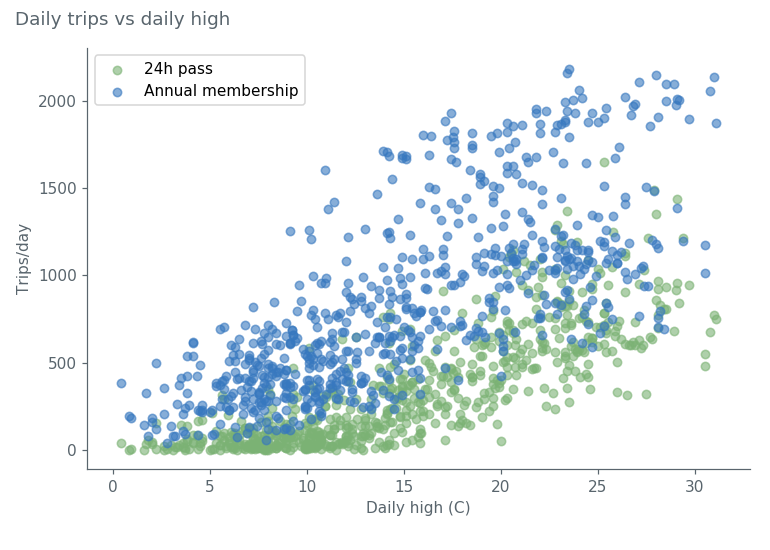

In [8]:
plot = mobi.plots.Plot()
wdf.plot('Max Temp','24h trips',
                    ax=plot.ax,kind='scatter',
                    label='24h pass',
                    alpha=0.6,
                    color=plot.fg_color,
                    s=30)
wdf.plot('Max Temp','365d trips',
                    ax=plot.ax,
                    kind='scatter',
                    label='Annual membership',
                    alpha=0.6,
                    color=plot.fg_color2,
                    s=30)
plot.ax.set_xlabel('Daily high (C)')
plot.ax.legend()
plot.ax.set_ylabel("Trips/day")
plot.title("Daily trips vs daily high")
plot.tight_layout()

Let's drop out days with any precipitation to remove the effect of rainy days.

<IPython.core.display.Javascript object>


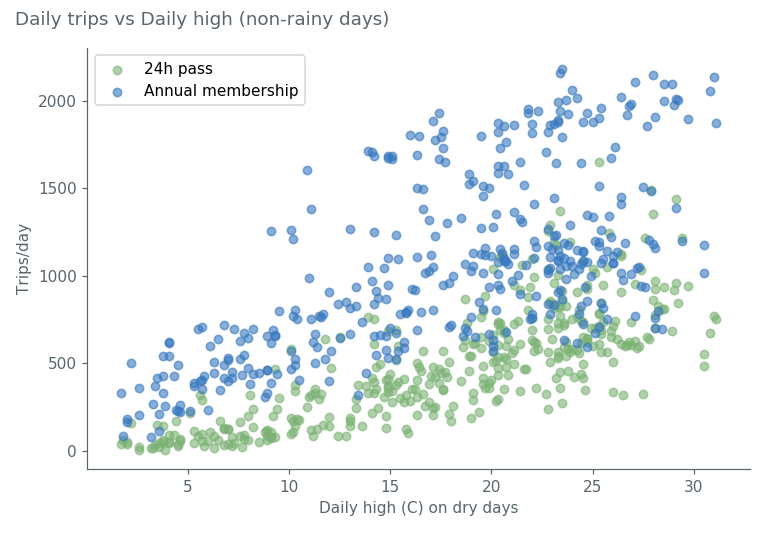

In [9]:
plot = mobi.plots.Plot()
wdf[~idxrainy].plot('Max Temp','24h trips',
                    ax=plot.ax,kind='scatter',
                    label='24h pass',
                    alpha=0.6,
                    color=plot.fg_color,
                    s=30)
wdf[~idxrainy].plot('Max Temp','365d trips',
                    ax=plot.ax,
                    kind='scatter',
                    label='Annual membership',
                    alpha=0.6,
                    color=plot.fg_color2,
                    s=30)
plot.ax.set_xlabel('Daily high (C) on dry days')
plot.ax.legend()
plot.title("Daily trips vs Daily high (non-rainy days)")
plot.ax.set_ylabel("Trips/day")
plot.tight_layout()


Both groups unsurprisingly show an obvious correlation between how many people are taking bikes out and daily temperature. Daily pass users look like they pretty much bottom out below about 10 degrees, while annual members seem a bit more willing to brave the colder days.

But we're obviously more interested in how Vancouverites adapt to the rain. Do we tough it out on rainy days, or give up our bikes when it drizzles a little bit?

Again I'll drop days with zero rain to simplify things a bit.

<IPython.core.display.Javascript object>


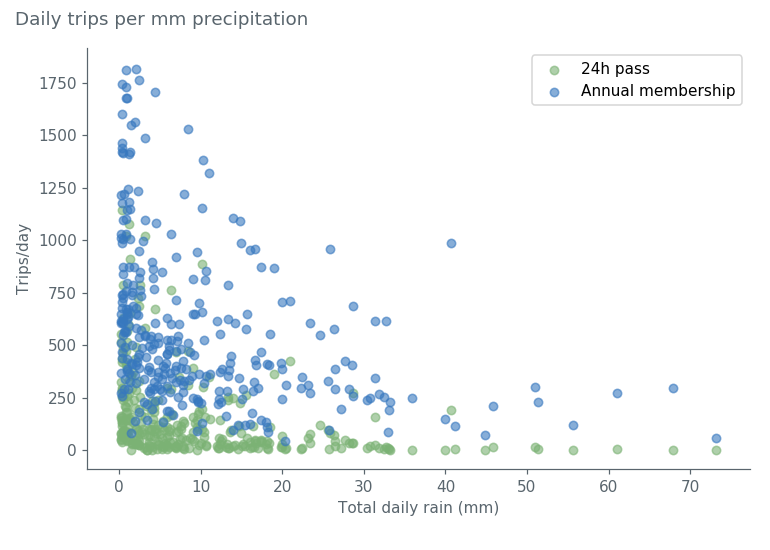

In [10]:
plot = mobi.plots.Plot()
wdf[idxrainy].plot('Total Precipmm','24h trips',
                    ax=plot.ax,kind='scatter',
                    label='24h pass',
                    alpha=0.6,
                    color=plot.fg_color,
                    s=30)
wdf[idxrainy].plot('Total Precipmm','365d trips',
                    ax=plot.ax,
                    kind='scatter',
                    label='Annual membership',
                    alpha=0.6,
                    color=plot.fg_color2,
                    s=30)
plot.ax.set_xlabel('Total daily rain (mm)')
plot.ax.legend()
plot.title("Daily trips per mm precipitation")
plot.ax.set_ylabel("Trips/day")
plot.tight_layout()

I've looked into this relationship in more depth in a previous post so again if you want more information about how temperature and rain affect daily trips you can [read lots more about it](http://notes.mikejarrett.ca/what-really-affects-bikeshare-use-in-vancouver/). But here we're more interested in how behaviours differs between membership types. So let's see how the ratio of annual member trips to 24h pass trips differs for different amounts of rain.

In [11]:
ranges = np.append(np.arange(0, 40, 5),[70])
wdf_grp = wdf.groupby(pd.cut(wdf["Total Precipmm"], ranges)).mean()
wdf_grp_cnt = wdf.groupby(pd.cut(wdf["Total Precipmm"], ranges)).size()
wdf_grp.columns.name = 'Averages'
wdf_grp[['Max Temp','Min Temp','Total Precipmm','24h trips','365d trips','Other trips']]

Averages         Max Temp  Min Temp  Total Precipmm   24h trips  365d trips  \
Total Precipmm                                                                
(0, 5]          12.686014  7.630070        1.898601  228.972028  734.734266   
(5, 10]         10.668254  6.541270        7.315873  116.031746  460.507937   
(10, 15]        10.725714  6.877143       12.474286  119.828571  537.857143   
(15, 20]        10.507407  7.296296       17.411111   57.851852  422.555556   
(20, 25]        10.788889  7.100000       22.322222   82.888889  383.111111   
(25, 30]        10.716667  6.925000       27.125000   62.666667  409.666667   
(30, 35]        10.820000  5.900000       32.030000   26.100000  309.900000   
(35, 70]         9.545455  6.272727       48.663636   22.818182  273.181818   

Averages        Other trips  
Total Precipmm               
(0, 5]           271.657343  
(5, 10]          186.873016  
(10, 15]         193.457143  
(15, 20]         143.740741  
(20, 25]         156.222222  
(25, 30]         167.500000  
(30, 35]         135.000000  
(35, 70]          93.000000

<IPython.core.display.Javascript object>


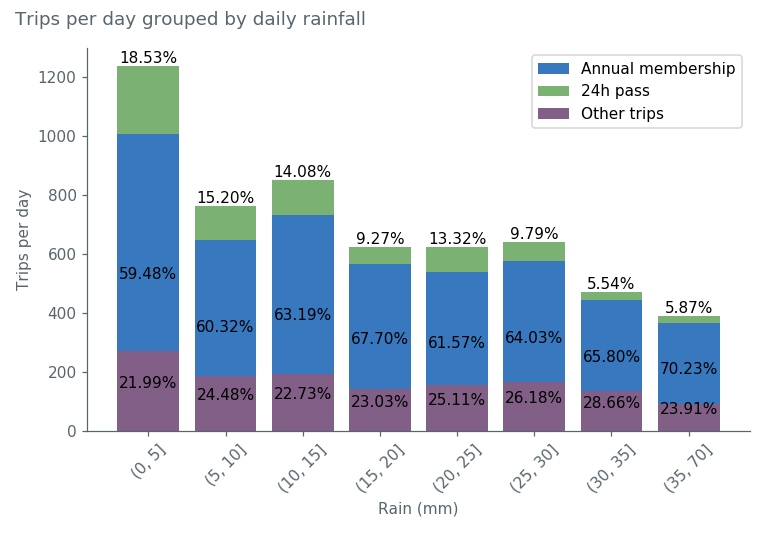

In [12]:
plot = mobi.plots.Plot()
labels = [str(x) for x in wdf_grp.index]
p2 = plot.ax.bar(labels, wdf_grp["365d trips"],bottom=wdf_grp["Other trips"],label='Annual membership')
p3 = plot.ax.bar(labels, wdf_grp["24h trips"],bottom=wdf_grp["365d trips"]+wdf_grp["Other trips"],label="24h pass")
p1 = plot.ax.bar(labels, wdf_grp["Other trips"],label="Other trips")
plot.ax.legend()
plot.ax.set_ylabel("Trips per day")
plot.ax.set_xlabel("Rain (mm)")

def autolabel(rects1,rects2,rects3):
    """
    Attach a text label above each bar displaying its height
    """
    for rect1,rect2,rect3 in zip(rects1,rects2,rects3):
        height1 = rect1.get_height()
        height2 = rect2.get_height()
        height3 = rect3.get_height()
        ratio1 = 100*rect1.get_height()/(rect1.get_height() + rect2.get_height()+ rect3.get_height())
        ratio2 = 100*rect2.get_height()/(rect1.get_height() + rect2.get_height()+ rect3.get_height())
        ratio3 = 100*rect3.get_height()/(rect1.get_height() + rect2.get_height()+ rect3.get_height())

        plot.ax.text(rect1.get_x() + rect1.get_width()/2., 0.5*height1,
                "{:04.2f}%".format(ratio1),
                ha='center', va='bottom')
        plot.ax.text(rect2.get_x() + rect2.get_width()/2., 0.5*(height2+height1),
                "{:04.2f}%".format(ratio2),
                ha='center', va='bottom')
        plot.ax.text(rect3.get_x() + rect2.get_width()/2., height1+height2 +height3,
                "{:04.2f}%".format(ratio3),
                ha='center', va='bottom')

autolabel(p1,p2,p3)
plot.title("Trips per day grouped by daily rainfall")

plot.tight_layout()

The percentage of riders who have annual passes increases as the days get rainier. People with annual memberships are pretty resiliant, even when it rains a whole lot. Casual riders are clearly more rain-averse. 

## Trip Length by Membership Type

I've heard a few times now about new users not understanding Mobi's pricing model. When people buy a 24h pass, they might not realize that entitles them to unlimited 30 minute trips, not unlimited use of a bike. Let's look and see whether these are just isolated complaints by people who don't read the instructions or if this is actually a common phenomenon.

In [13]:
idx30min = np.array(df['Duration (min.)'] > 30)
idx60min = np.array(df['Duration (min.)'] > 60)
idxot = (~idxplus & idx30min) | (idxplus & idx60min) 

<IPython.core.display.Javascript object>


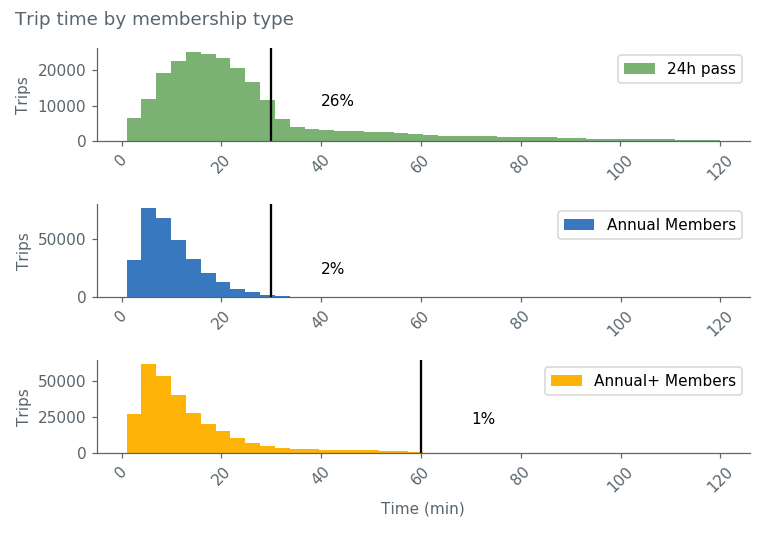

In [14]:
plot = mobi.plots.Plot(3,1)

plot.ax[0].hist(df.loc[idx24 & (df['Duration (min.)'] <120),'Duration (min.)'],
                bins=40,
                color=plot.fg_color,
                label='24h pass')
ot_ratio = 100*sum(idxot & idx24)/sum(idx24)
plot.ax[0].text(40,10000,"{:0.0f}%".format(ot_ratio))
plot.ax[0].axvline(30,color='k')

plot.ax[1].hist(df.loc[idx365 & (df['Duration (min.)']<120),'Duration (min.)'],
                bins=40,
                color=plot.fg_color2,
                label='Annual Members')
ot_ratio = 100*sum(idxot & idx365)/sum(idx365)
plot.ax[1].text(40,20000,"{:0.0f}%".format(ot_ratio))
plot.ax[1].axvline(30,color='k')

plot.ax[2].hist(df.loc[idx365p & (df['Duration (min.)']<120),'Duration (min.)'],
                bins=40,
                color=plot.fg_color3,
                label='Annual+ Members')
ot_ratio = 100*sum(idxot & idx365p)/sum(idx365p)
plot.ax[2].text(70,20000,"{:0.0f}%".format(ot_ratio))
plot.ax[2].axvline(60,color='k')

for a in plot.ax:
    a.legend()
plot.ax[2].set_xlabel('Time (min)')
plot.title("Trip time by membership type")
plot.tight_layout()

Here I've made histogrames of trip duration split up by membership type. There's no two ways around it. Annual members take mostly short trips under 20 minutes. People with "plus" memberships, which entitle them to 60 minutes per trip, show almost the exact same behavious as normal annual members with just a few more trips between 30 and 60 minutes.

People figure it out, to a degree. We can measure this by labelling each trip by how many trips that user has taken to that point. In other words, group trips as 1st trip, 2nd trip, and so on, then take the ratio of trips which ran overtime in each group. 

When we do this for all trips, we see a pretty obvious logarithmic decay, implying that for each additional trip a user takes it becomes less likely that the trip will run overtime. But we see a bit different behavious when we split between daily and annual passholders. 

For single day passholders, a user's first trip runs overtime about 50% of the time. By a user's 5th trip, this has dropped to about 20% where it holds steady. For annual users, the first trip is also the most likely to run overtime but in this case it's only about 5% of the time, and gets even smaller after that. I'd say there's some work to be done in educating casual users about exactly what their pass entitles them to. Annual members seem to have it figured out.

In [15]:
nth_trip = df.reset_index().groupby('Account').cumcount()+1

df = df.reset_index()
df.loc[nth_trip.index,'nth_trip'] = nth_trip.values
df = df.set_index('Departure')

df['is_ot'] = idxot

<IPython.core.display.Javascript object>


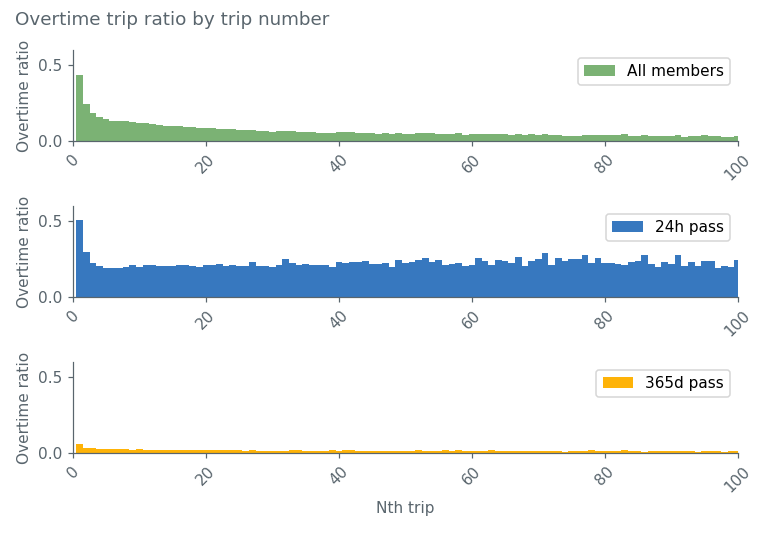

In [16]:
def make_ot_ratios(df):
    ot_ratios = [ (i,sum(gdf['is_ot'])/len(gdf)) for i, gdf in df[['nth_trip','is_ot']].groupby('nth_trip')]
    n_trips = [x[0] for x in ot_ratios]
    ot_ratios = [x[1] for x in ot_ratios]
    return n_trips,ot_ratios
plot = mobi.plots.Plot(3)
plot.ax[0].bar(*make_ot_ratios(df),1,color=plot.fg_color,label='All members')
plot.ax[1].bar(*make_ot_ratios(df[idx24]),1,color=plot.fg_color2,label='24h pass')
plot.ax[2].bar(*make_ot_ratios(df[idx365all]),1,color=plot.fg_color3,label='365d pass')

for a in plot.ax:
    a.set_ylabel('Overtime ratio')
    a.set_xlim((0,100))
    a.set_ylim((0,0.6))
    a.legend()
plot.ax[2].set_xlabel("Nth trip")
plot.title("Overtime trip ratio by trip number")
plot.tight_layout()

## Distance and speed

It's maybe not as important to peoples' bank accounts, but we can also look at how fast and how far Mobi users take their bikes. Mobi tracks a trip's actual distance (presumably there's an odometer in the onboard computer) not just the point to point distance between stations. For annual members, we see a much tighter distribution with a peak around ~1km and tailing off to ~7km. Again, this is consistent with people using Mobis for transportation on trips not well served by transit. For daily users, the distribution is much broader, with a wide peak around 1-3km and a long tail out to 12km. We even see a bump around 10km, and it turns out ~10km trips are heavily dominated by the Stanly Park stations since that's about the distance around the Stanley Park seawall.

<IPython.core.display.Javascript object>


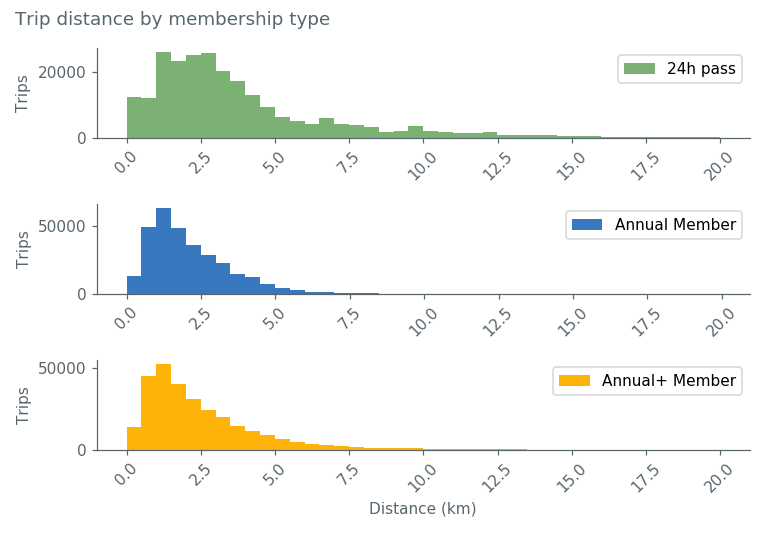

In [17]:
df['Covered distance (km)'] = df['Covered distance (m)']/1000

dmax = 20
plot = mobi.plots.Plot(3,1)

plot.ax[0].hist(df.loc[idx24 & (df['Covered distance (km)']<dmax),
                       'Covered distance (km)'],bins=40,color=plot.fg_color,label='24h pass')
plot.ax[1].hist(df.loc[idx365 & (df['Covered distance (km)']<dmax),
                       'Covered distance (km)'],bins=40,color=plot.fg_color2,label='Annual Member')
plot.ax[2].hist(df.loc[idx365p & (df['Covered distance (km)']<dmax),
                       'Covered distance (km)'],bins=40,color=plot.fg_color3,label='Annual+ Member')


for a in plot.ax:

    a.legend()
plot.ax[2].set_xlabel('Distance (km)')
plot.title("Trip distance by membership type")
plot.tight_layout()


Another way of looking at the distance information is to compare the actual distance travelled to the straight-line distance between the Departure and Return stations for each trip. This tells us about how direct or circuitous a trip is.

In [18]:
from math import sin, cos, sqrt, atan2, radians


def straightline_distance(p1,p2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(p1[0])
    lon1 = radians(p1[1])
    lat2 = radians(p2[0])
    lon2 = radians(p2[1])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance*1000

df['Straight line'] = df['stations coords'].map(lambda x: straightline_distance(*x))
df['Distance ratio'] = df['Covered distance (m)']/df['Straight line']


<IPython.core.display.Javascript object>


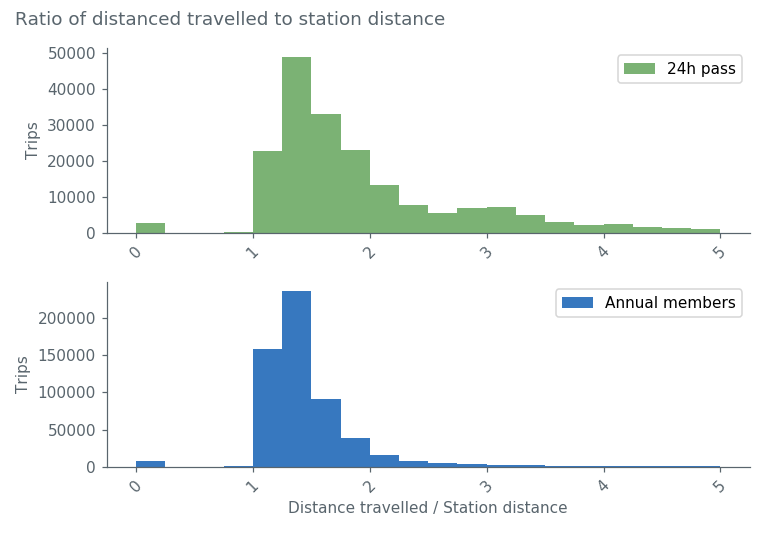

In [19]:
plot = mobi.plots.Plot(2)
b1 = plot.ax[0].hist(df.loc[idx24,'Distance ratio'].dropna().values,
                     range=(0,5),
                     bins=20,
                     label="24h pass",color=plot.fg_color)
b2 = plot.ax[1].hist(df.loc[idx365all,'Distance ratio'].dropna().values,
                     range=(0,5),
                     bins=20,label="Annual members",color=plot.fg_color2)
plot.ax[1].set_xlabel('Distance travelled / Station distance')
plot.title("Ratio of distanced travelled to station distance")
for a in plot.ax:
    a.legend()
plot.tight_layout()

Obviously the most direct route will only be exactly a straight line in a few cases where the departure and return stations are on the same street. But we still see annual members routinely taking trips with a distance ratio between 1-2, while daily pass users take much more circuitous routes to their destination. We also see a small number of trips with distance ratios below one, which doesn't strictly make sense. These are probably cases where the odometer on the bike is broken. I'm sure there are also cases where people have taken a bike in a car for some distance, or even carried it. People do weird things with their Mobis -- I've even seen someone with a Mobi in my apartment building's elevator.

Average speed is also several km/h higher for annual members than daily pass users. As we've seen over and over, annual members have places to go, while daily pass users generally want to enjoy the sights and sounds of the city.

<IPython.core.display.Javascript object>


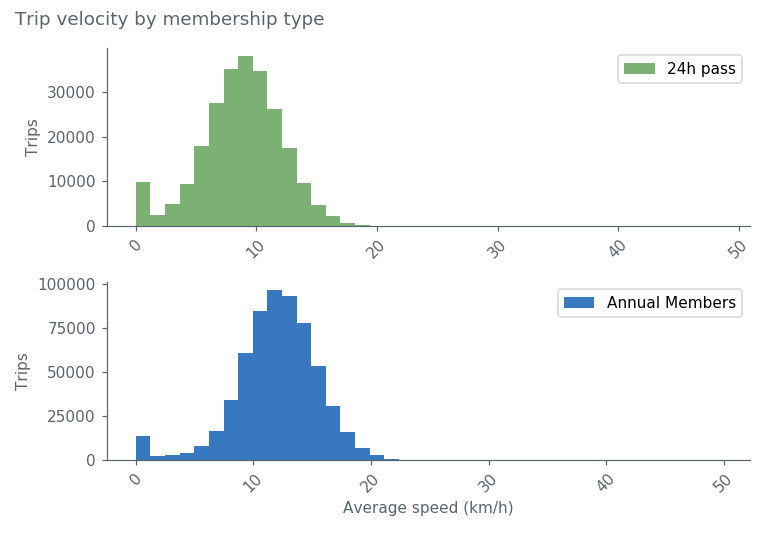

In [20]:
dmax = 50

plot = mobi.plots.Plot(2)

plot.ax[0].hist(df.loc[idx24 & (df['average speed (km/h)']<dmax),
                       'average speed (km/h)'],bins=40,color=plot.fg_color,label='24h pass')
plot.ax[1].hist(df.loc[idx365all & (df['average speed (km/h)']<dmax),
                       'average speed (km/h)'],bins=40,color=plot.fg_color2,label='Annual Members')
#plot.ax[2].hist(df.loc[idx365p & (df['average speed (km/h)']<dmax),
#                       'average speed (km/h)'],bins=40,color=plot.fg_color3,label='Annual+ Member')


for a in plot.ax:

    a.legend()
plot.ax[1].set_xlabel('Average speed (km/h)')
plot.title("Trip velocity by membership type")
plot.tight_layout()


## East Van additions

The big Mobi news in 2018 was adding stations east of Main. Prior to this expansion one of the main complaints that I heard during the inititial rollout was lack of East Van stations, so I was interested to see how much use these stations got once they appeared. To this end, I've divided stations into three groups: East (all stations east of Main), Core (downtown peninsula and the southern rim of False Creek south to about 6th Ave) and South (all station south of 6th and west of Main). Breaking out the southwest portion of the coverage area gives us a comparable area to East Van with lower density than the core and fewer tourist attractions than the downtown core and False Creek. I've marked the areas and the stations in the map below.

In [21]:
# Get trips that start or stop east of main
long = -123.1007
idxdepev = np.array(df['Departure coords'].map(lambda x: float(x[1]) > long))
idxretev = np.array(df['Return coords'].map(lambda x: float(x[1]) > long))

# Get trips that start or stop west of main / south of false creek (approx)
lat = 49.266
idxdepsv = np.array(df['Departure coords'].map(lambda x: (float(x[0]) < lat) & (float(x[1]) < long)))
idxretsv = np.array(df['Return coords'].map(lambda x: (float(x[0]) < lat) & (float(x[1]) < long)))

# core stations trips
idxdepcent = ~idxdepev  & ~idxdepsv 

ev_stations = sorted(set(df.loc[idxdepev,'Departure station']))

sv_stations = sorted(set(df.loc[idxdepsv,'Departure station']))

cent_stations = sorted(set(df.loc[idxdepcent,'Departure station']))

<IPython.core.display.Javascript object>


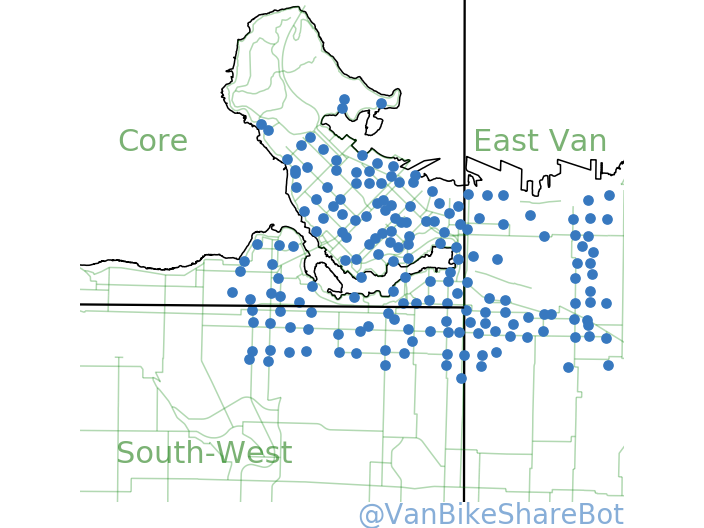

In [22]:
import cartopy.crs as ccrs
plot = mobi.geomobi.GeoPlot()
plot.addgeo('/home/msj/shapes/bikeways.shp',facecolor="none",edgecolor='green',zorder=95,alpha=0.3)
plot.addgeo('/home/msj/shapes/shoreline2002.shp',facecolor='#ffffff',zorder=1)
plot.ax.scatter(stationdf['coordinates'].map(lambda x: x[1]).values,
                stationdf['coordinates'].map(lambda x: x[0]).values,
               transform=ccrs.PlateCarree(),
               zorder=100)
plot.ax.hlines(lat,long-1,long,zorder=101,transform=ccrs.PlateCarree())
plot.ax.vlines(long,lat+1,lat-1,transform=ccrs.PlateCarree())
plot.ax.text(long+0.002,lat+0.025,"East Van",transform=ccrs.PlateCarree(),alpha=1,size=20,color=plot.fg_color2)
plot.ax.text(long-0.085,lat+0.025,"Core",transform=ccrs.PlateCarree(),color=plot.fg_color2,alpha=1,size=20)
plot.ax.text(long-0.085,lat-0.025,"South-West",transform=ccrs.PlateCarree(),color=plot.fg_color2,alpha=1,size=20);

<IPython.core.display.Javascript object>


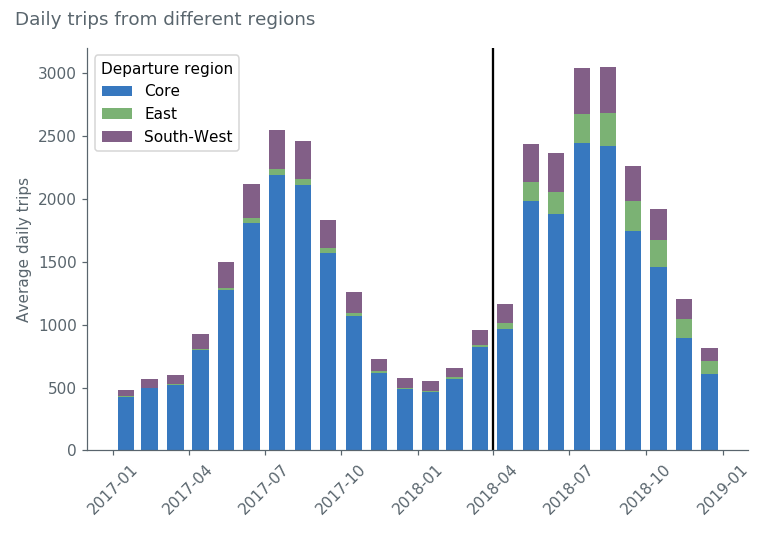

In [23]:
plot = mobi.plots.Plot()

b1 = plot.ax.bar(*tmdf(df[idxdepcent]),20,label='Core')
b2 = plot.ax.bar(*tmdf(df[idxdepev]),20,bottom=[x.get_height() for x in b1],label='East')
b3 = plot.ax.bar(*tmdf(df[idxdepsv]),20,bottom=[x.get_height()+y.get_height() for x,y in zip(b1,b2)],label='South-West')

plot.ax.legend(loc=2,title="Departure region")
plot.ax.axvline('2018-04-01',color='k')
plot.ax.set_ylabel('Average daily trips')
plot.title("Daily trips from different regions")
plot.tight_layout()

I've marked on the plot April 2018 when Mobi first advertised stations expanding into East Van. There were a handful of east of Main stations before then, but they only accounted for a small fraction of total trips. Since the East Van expansion, the fraction of trip starting in East Van has grown to be comparable to the South-West region. I might even argue that East Van has been responsible for a good chunk of Mobi's growth in the last year.

We can also break this down by how many trips per day the average station in each region sees. The small number of original East of Main stations were heavily used, but the addition of more East Van stations in lower density regions has made them on average used less often. As Mobi expands into less dense neighbourhoods, it's not surprising to see diminishing returns on ridership for each new station added. That said, the network effect is still important. Having stations reliably located throughout the region even in less dense areas is likely good for the health of the system as a whole.

In [24]:
monthly_stations = [len(set(gdf['Departure station'])) for i,gdf in df.groupby(pd.Grouper(freq='m'))]
monthly_ev_stations = [len([x for x in set(gdf['Departure station']) if x in ev_stations]) for i,gdf in df.groupby(pd.Grouper(freq='m'))]
monthly_sv_stations = [len([x for x in set(gdf['Departure station']) if x in sv_stations]) for i,gdf in df.groupby(pd.Grouper(freq='m'))]
monthly_cent_stations = [len([x for x in set(gdf['Departure station']) if x in cent_stations]) for i,gdf in df.groupby(pd.Grouper(freq='m'))]

<IPython.core.display.Javascript object>


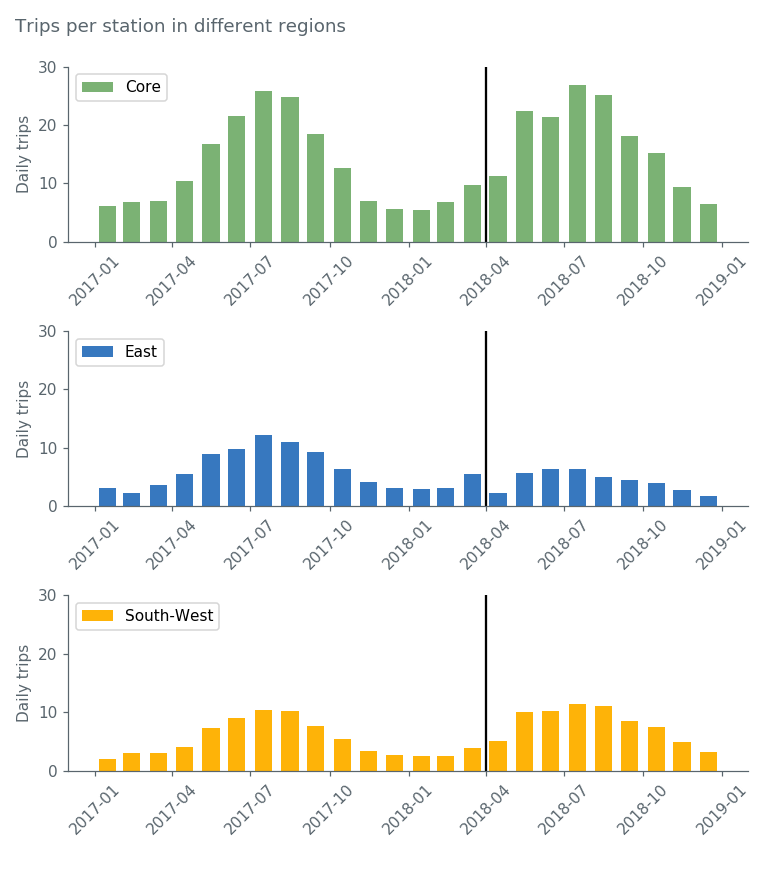

In [25]:
plot = mobi.plots.Plot(3)
idx = tmdf(df)[0]
b1 = plot.ax[0].bar(idx,tmdf(df[idxdepcent])[1]/monthly_cent_stations,20,label='Core',color=plot.fg_color)
b2 = plot.ax[1].bar(idx,tmdf(df[idxdepev])[1]/monthly_ev_stations,20,label='East',color=plot.fg_color2)
b3 = plot.ax[2].bar(idx,tmdf(df[idxdepsv])[1]/monthly_sv_stations,20,label='South-West',color=plot.fg_color3)

for ax in plot.ax:
    ax.legend(loc=2)
    ax.axvline('2018-04-01',color='k')
    ax.set_ylabel('Daily trips')
    ax.set_ylim(0,30)
plot.f.set_figheight(8)
plot.title("Trips per station in different regions")
plot.tight_layout()

There's a lot more in this dataset that I haven't covered here. I have a couple more post ideas worked out that should be coming soon -- for example, I'll show which pairs of stations make up the most common trips in various situations. If you have questions about this post, or ideas that you'd like to see explored in the future, don't hesitate to contact me [on twitter](twitter.com/mikejarrett_) or by email at mike@mikejarrett.ca.